In [ ]:
from utils import *

NOTEBOOK_ID = '08'
MAKE_FASTA = False
EVALUATE_MODEL = False
TRAIN_ENSEMBLE = False

# make affinity matrix

In [ ]:
if MAKE_FASTA:
    initial_df = pd.read_pickle(f'{EMBEDDING_DIR}/01-dataset/esm2_t33_650M_UR50D-layer33-representations.pkl').drop_duplicates(subset='AAseq',keep=False)
    df_to_fasta(initial_df,'ID','AAseq',f'{INITIAL_GENERALIZABILITY_DIR}/initial_dedup.faa')
# !clustalo -i ../../02-OUTPUT/13-evaluate_initial_generalizability/initial_dedup.faa --distmat-out=initial_distance_matrix.txt --full --percent-id --output-order=tree-order --threads=10 --force

out_file = f'{INITIAL_GENERALIZABILITY_DIR}/initial_distance_matrix.pkl'
if not os.path.isfile(out_file):
    distance_df = pd.read_table(f'{INITIAL_GENERALIZABILITY_DIR}/initial_distance_matrix.txt',skiprows=1,sep=' ',index_col=0,header=None)
    distance_df.columns = distance_df.index
    distance_df.to_pickle(out_file)
else: 
    distance_df = pd.read_pickle(out_file)
distance_df.index.name = None

# determine number of clusters

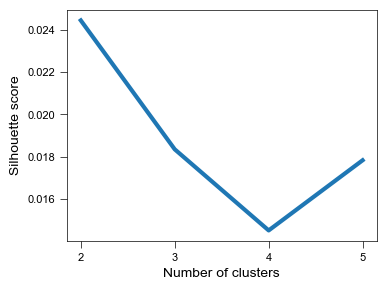

In [ ]:
out_file = f'{INITIAL_GENERALIZABILITY_DIR}/silhouette_scores.npy'
if not os.path.isfile(out_file):
    max_clusters = 5
    silhouette_scores = calculate_silhouette(distance_df.to_numpy(), max_clusters)
    np.save(out_file,silhouette_scores)
else:
    silhouette_scores = np.load(out_file,allow_pickle=True)

plt.figure(figsize=(4,3))
g = sns.lineplot(x=range(2, len(silhouette_scores) + 2), y=silhouette_scores,linewidth=3)
plt.xticks(np.arange(2, int(6), 1))
g.set(xlabel="Number of clusters",ylabel="Silhouette score")
if SAVE_FIGURES:
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-silhouette_score.png',**FIGURE_PARAMS)

# run spectral clustering

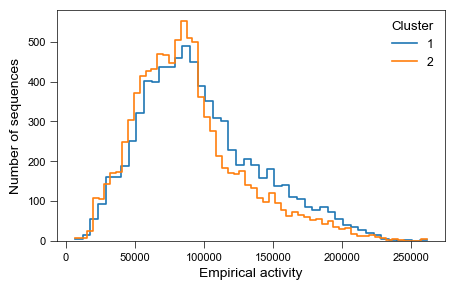

In [5]:
out_file = f'{INITIAL_GENERALIZABILITY_DIR}/cluster_df.pkl'
if not os.path.isfile(out_file):
    initial_df = pd.read_pickle(f'{EMBEDDING_DIR}/01-dataset/esm2_t33_650M_UR50D-layer33-representations.pkl').drop_duplicates(subset='AAseq',keep=False)
    clustering = SpectralClustering(n_clusters=2, affinity='precomputed')
    labels = clustering.fit_predict(distance_df.to_numpy())
    cluster_df = initial_df[['ID','AAseq','activity']].copy()
    cluster_df['cluster'] = labels+1
    cluster_df.to_pickle(out_file)
else:
    cluster_df = pd.read_pickle(out_file)

plt.figure(figsize=(5,3))
tab10 = sns.color_palette('tab10')
g = sns.histplot(data=cluster_df.query('cluster == 1'),x='activity',element='step',color=tab10[0],label='1',fill=False)
sns.histplot(data=cluster_df.query('cluster == 2'),x='activity',element='step',color=tab10[1],label='2',fill=False)
g.set(xlabel='Empirical activity',ylabel='Number of sequences')
g.legend(title='Cluster',frameon=False)
if SAVE_FIGURES:
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-histplot_spectral_clustering.png',**FIGURE_PARAMS)

In [6]:
cluster_df = pd.read_pickle(f'{INITIAL_GENERALIZABILITY_DIR}/cluster_df.pkl')
cluster_df['activity_scaled'] = preprocessing.StandardScaler().fit_transform( cluster_df['activity'].to_numpy().reshape(-1,1))
y = cluster_df['activity_scaled'].to_numpy()
threshold = cluster_df['activity_scaled'].median()
cluster_df['activity_bin'] = cluster_df['activity_scaled'].apply(lambda x: x >= 1.0)
cluster_df.to_pickle(f'{INITIAL_GENERALIZABILITY_DIR}/spectral_cluster_dataset.pkl')

# train/test ADhunter with simple encoding

In [ ]:
if EVALUATE_MODEL:
    out_file = f'{INITIAL_GENERALIZABILITY_DIR}/datasets_v1.pkl'
    if not os.path.isfile(out_file):
        cluster_df['activity_scaled'] = preprocessing.StandardScaler().fit_transform( cluster_df['activity'].to_numpy().reshape(-1,1))
        y = cluster_df['activity_scaled'].to_numpy()
        threshold = cluster_df['activity_scaled'].median()
        y_cont = y.reshape(-1, 1)
        y_bin = (y >= threshold).astype(np.int64).reshape(-1, 1)
        datasets = {}
        for state in tqdm(range(1,11)):
            trainval_df = cluster_df.query(f'cluster == 1')
            X_trainval = np.asarray([[aa_to_i[aa] for aa in x] for x in trainval_df['AAseq']])
            y_trainval = trainval_df['activity_scaled'].to_numpy().reshape(-1,1)
            y_trainval_bin= (y_trainval >= threshold).astype(np.int64).reshape(-1, 1)
            splitter = StratifiedShuffleSplit(n_splits=1,train_size=0.8,random_state=state)
            train_idx, val_idx = list(splitter.split(X_trainval, y_trainval_bin))[0]
            X_train = torch.tensor(X_trainval[train_idx])
            y_train = torch.tensor(y_trainval[train_idx])
            X_val = torch.tensor(X_trainval[val_idx])
            y_val = torch.tensor(y_trainval[val_idx])

            test_df = cluster_df.query(f'cluster == 2')
            X_test = np.asarray([[aa_to_i[aa] for aa in x] for x in test_df['AAseq']])
            y_test = test_df['activity_scaled'].to_numpy().reshape(-1,1)
            y_test_bin = (y_test >= threshold).astype(np.int64).reshape(-1, 1)
            splitter = StratifiedShuffleSplit(n_splits=1,random_state=state)
            test_idx = np.concatenate(list(splitter.split(X_test, y_test_bin))[0])
            X_test = torch.tensor(X_test[test_idx])
            y_test = torch.tensor(y_test[test_idx])
            y_test_bin = torch.tensor(y_test_bin)
            dataset = (X_train, None, y_train), (X_val, _, y_val), (X_test, y_test_bin, y_test)
            datasets[state] = dataset
            save_dict(out_file,datasets)
    else:
        datasets = load_dict(out_file)

    for state, dataset in datasets.items():
        train_ADhunter(dataset,out_dir=f'{INITIAL_GENERALIZABILITY_DIR}/02-evaluate',out_name=f'spectral_cluster',version='v1',random_state=state)
        test_ADhunter(dataset,out_dir=f'{INITIAL_GENERALIZABILITY_DIR}/02-evaluate',out_name=f'spectral_cluster',version='v1',random_state=state)
_, test_df = parse_results(f'{INITIAL_GENERALIZABILITY_DIR}/02-evaluate/03-results')
test_df = test_df[test_df['params'].apply(lambda x: 'v1' in x)]
test_df['state'] = test_df['params'].apply(lambda x: x.split('_state')[-1])
display(test_df.groupby('state')[['y_test','y_test_hat']].apply(lambda x: pearsonr(x['y_test'],x['y_test_hat'])[0]).mean(),
        test_df.groupby('state')[['y_test','y_test_hat']].apply(lambda x: spearmanr(x['y_test'],x['y_test_hat'])[0]).mean(),
        test_df.groupby('state')[['y_test','y_test_hat']].apply(lambda x: mean_squared_error(x['y_test'],x['y_test_hat'],squared=False)).mean())

0.4164341874254534

0.38603368588409953

0.8839227113559792

# train/test ADhunter with neural encoding

In [ ]:
if EVALUATE_MODEL:
    out_file = f'{INITIAL_GENERALIZABILITY_DIR}/datasets_v2.pkl'
    if not os.path.isfile(out_file):
        initial_df = pd.read_pickle(f'{EMBEDDING_DIR}/01-dataset/esm2_t33_650M_UR50D-layer33-representations.pkl').drop_duplicates(subset='AAseq',keep=False)
        cluster_df['activity_scaled'] = preprocessing.StandardScaler().fit_transform( cluster_df['activity'].to_numpy().reshape(-1,1))
        y = cluster_df['activity_scaled'].to_numpy()
        threshold = cluster_df['activity_scaled'].median()
        y_cont = y.reshape(-1, 1)
        y_bin = (y >= threshold).astype(np.int64).reshape(-1, 1)
        datasets = {}
        for state in tqdm(range(1,4)):
            trainval_df = cluster_df.query(f'cluster == 1')
            X_trainval = np.asarray([np.array(emb) for emb in initial_df.loc[trainval_df.index,'esm2_t33_650M_UR50D']])
            y_trainval = trainval_df['activity_scaled'].to_numpy().reshape(-1,1)
            y_trainval_bin= (y_trainval >= threshold).astype(np.int64).reshape(-1, 1)
            splitter = StratifiedShuffleSplit(n_splits=1,train_size=0.8,random_state=state)
            train_idx, val_idx = list(splitter.split(X_trainval, y_trainval_bin))[0]
            X_train = torch.tensor(X_trainval[train_idx])
            y_train = torch.tensor(y_trainval[train_idx])
            X_val = torch.tensor(X_trainval[val_idx])
            y_val = torch.tensor(y_trainval[val_idx])

            test_df = cluster_df.query(f'cluster == 2')
            X_test = np.asarray([np.array(emb) for emb in initial_df.loc[test_df.index,'esm2_t33_650M_UR50D']])
            y_test = test_df['activity_scaled'].to_numpy().reshape(-1,1)
            y_test_bin = (y_test >= threshold).astype(np.int64).reshape(-1, 1)
            splitter = StratifiedShuffleSplit(n_splits=1,random_state=state)
            test_idx = np.concatenate(list(splitter.split(X_test, y_test_bin))[0])
            X_test = torch.tensor(X_test[test_idx])
            y_test = torch.tensor(y_test[test_idx])
            y_test_bin = torch.tensor(y_test_bin)
            dataset = (X_train, None, y_train), (X_val, _, y_val), (X_test, y_test_bin, y_test)
            datasets[state] = dataset
            save_dict(out_file,datasets)
    else:
        datasets = load_dict(out_file)

    for state, dataset in datasets.items():
        train_ADhunter(dataset,out_dir=f'{INITIAL_GENERALIZABILITY_DIR}/02-evaluate',out_name=f'spectral_cluster',version='v2',random_state=state)
        test_ADhunter(dataset,out_dir=f'{INITIAL_GENERALIZABILITY_DIR}/02-evaluate',out_name=f'spectral_cluster',version='v2',random_state=state)

_, test_df = parse_results(f'{INITIAL_GENERALIZABILITY_DIR}/02-evaluate/03-results')
test_df = test_df[test_df['params'].apply(lambda x: 'v2' in x and 'l2' not in x)]
test_df['state'] = test_df['params'].apply(lambda x: x.split('_state')[-1])
display(test_df.groupby('state')[['y_test','y_test_hat']].apply(lambda x: pearsonr(x['y_test'],x['y_test_hat'])[0]).mean(),
        test_df.groupby('state')[['y_test','y_test_hat']].apply(lambda x: spearmanr(x['y_test'],x['y_test_hat'])[0]).mean(),
        test_df.groupby('state')[['y_test','y_test_hat']].apply(lambda x: mean_squared_error(x['y_test'],x['y_test_hat'],squared=False)).mean())

0.4755436857973642

0.4673471398731696

0.8555316503279496

# train/test ADhunter ensemble
* train on largest cluster
* validate on second largest cluster
* test on third largest cluster

In [ ]:
if TRAIN_ENSEMBLE:
    datasets = load_dict(f'{INITIAL_GENERALIZABILITY_DIR}/datasets_v2.pkl')    
    for state,dataset in datasets.items():
        train, val, _ = dataset
        X_train, _, y_train = train
        X_val, _, y_val = val

        query_df = pd.read_csv(f'{HAMMING_ENSEMBLE_DIR}/03-results/top_models.csv')
        df_filtered = pd.read_csv(f'{HAMMING_ENSEMBLE_DIR}/03-results/model_testing_filtered.csv').set_index('file')
        
        out_dir = f'{INITIAL_GENERALIZABILITY_DIR}/02-evaluate'
        _, selected_indices = select_maximally_different_arrays(df_filtered.to_numpy(), 20)
        hits_df = df_filtered.reset_index()
        hits_df = hits_df.loc[selected_indices].set_index('file')
        for idx, row in query_df[query_df.file.isin(hits_df.index)].reset_index(drop=True).iterrows():
            print(f'==================={idx/20}===================')
            train_ds = TensorDataset(X_train.to(torch.float), y_train.to(torch.float))
            val_ds = TensorDataset(X_val.to(torch.float), y_val.to(torch.float))
            train_dl = DataLoader(train_ds, batch_size=row['batch_size'], shuffle=False)
            val_dl = DataLoader(val_ds, batch_size=row['batch_size'], shuffle=False)

            model = ADhunterSystem_v2(
                embedding_size=X_train[0].shape[1],
                hidden=row['hidden_size'], 
                kernel_size=row['kernel_size'], 
                dilation=row['dilation'], 
                num_res_blocks=row['num_res_blocks'],
                seq_len=X_train[0].shape[0]
                )

            OUTPUT_FILE = f"ADhunter_v2_h{row['hidden_size']}_k{row['kernel_size']}_d{row['dilation']}_r{row['num_res_blocks']}_b{row['batch_size']}_spectralclustering_state{state}"
            csv_logger = CSVLogger(f"{out_dir}/01-logs",name=OUTPUT_FILE,version='')
            checkpoint_callback = ModelCheckpoint(dirpath=f"{out_dir}/02-models", monitor="val_loss", filename=OUTPUT_FILE, save_last=False)
            early_stopping = EarlyStopping('val_loss', patience=PATIENCE)
            trainer = pl.Trainer(accelerator='gpu', devices=1, callbacks=[checkpoint_callback, early_stopping], logger=[csv_logger], max_epochs=MAX_EPOCHS)
            trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)

            model = model.load_from_checkpoint(checkpoint_callback.best_model_path)
            torch.save(model.cpu().state_dict(), f'{out_dir}/02-models/{OUTPUT_FILE}.pt')
            
out_file = f'{INITIAL_GENERALIZABILITY_DIR}/ADhunter_v3_results.pkl'
if not os.path.isfile(out_file):
    datasets = load_dict(f'{INITIAL_GENERALIZABILITY_DIR}/datasets_v2.pkl')    
    test_df = None
    for state,dataset in datasets.items():
        _,_,test = dataset
        X_test,_,y_test = test
        new_predictions, new_uncertainty = get_new_uncertainty(X_test,state=state)
        tmp_df = pd.DataFrame([new_predictions,y_test.numpy().flatten()]).T
        tmp_df.columns=['y_test_hat','y_test']
        tmp_df['uncertainty'] = new_uncertainty
        tmp_df['params'] = 'ADhunter_ensemble'
        tmp_df['state'] = state
        test_df = pd.concat([test_df,tmp_df]).reset_index(drop=True)
    test_df.to_pickle(out_file)
else:
    test_df = pd.read_pickle(out_file)

display(test_df.groupby('state')[['y_test','y_test_hat']].apply(lambda x: pearsonr(x['y_test'],x['y_test_hat'])[0]).mean(),
        test_df.groupby('state')[['y_test','y_test_hat']].apply(lambda x: spearmanr(x['y_test'],x['y_test_hat'])[0]).mean(),
        test_df.groupby('state')[['y_test','y_test_hat']].apply(lambda x: mean_squared_error(x['y_test'],x['y_test_hat'],squared=False)).mean())

0.5124347511206796

0.5127042681446253

0.8256408644038814